In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import glob
from math import sqrt
SPINE_COLOR = 'gray'

In [3]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pdf',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8,       #'text.fontsize': 8, # was 10
              'legend.fontsize': 6.5, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'lines.linewidth' : 0.4,
              'lines.markersize' : 0.4,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

linewidth=497
DPI=96
#latexify(fig_width=linewidth/DPI, fig_height=int(linewidth/2.3/DPI))
latexify(fig_width=linewidth/DPI/1.7, fig_height=int(linewidth/2.3/DPI))

     seconds_offset  streamid  msg_number  ms_offset
0          0.109868         4           1    109.868
1          0.209954         4           2    209.954
2          0.309968         4           3    309.968
3          0.410012         4           4    410.012
4          0.510101         4           5    510.101
5          0.610130         4           6    610.130
6          0.710133         4           7    710.133
7          0.810195         4           8    810.195
8          0.910264         4           9    910.264
9          1.010335         4          10   1010.335
10         1.110456         4          11   1110.456
11         1.210470         4          12   1210.470
12         1.310522         4          13   1310.522
13         1.410564         4          14   1410.564
14         1.510623         4          15   1510.623
15         1.610692         4          16   1610.692
16         1.710707         4          17   1710.707
17         1.810767         4          18   18

     seconds_offset  streamid  msg_number  ms_offset
0          0.109505         4           1    109.505
1          0.209545         8           2    209.545
2          0.309606        12           3    309.606
3          0.409645        16           4    409.645
4          0.509689        20           5    509.689
5          0.609778        24           6    609.778
6          0.709807        28           7    709.807
7          0.809905        32           8    809.905
8          0.909922        36           9    909.922
9          1.010113        40          10   1010.113
10         1.110105        44          11   1110.105
11         1.210151        48          12   1210.151
12         1.310208        52          13   1310.208
13         1.410294        56          14   1410.294
14         1.510382        60          15   1510.382
15         1.610487        64          16   1610.487
16         1.710568        68          17   1710.568
17         1.810640        72          18   18

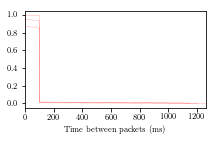

In [9]:
#CCDFs
# time between consecutive msgs (should be under the deadline) -> not working for full-eph since there are data holes
for f in glob.iglob('./*20191127*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                                    ['seconds_offset', 'streamid', 'length', 'msg_number'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number'])

    title=f
    del dfapp['length']

    #dfapp['perfectTimeDeviation'] = (dfapp.seconds_offset - dfapp.msg_number * 0.1)*1000
    #print(dfapp.perfectTimeDeviation.sort_values())
    
    
    #compute the time between two consecutive packets
    dfapp.sort_values(by='msg_number')
    dfapp['ms_offset'] = dfapp.seconds_offset.apply(lambda x: x * 1000) # from s to ms
    print(dfapp)
    
    i = dfapp.ms_offset[0];
    timeBetween = [];
    for j in dfapp['ms_offset']:
        timeBetween.append(j-i)
        i = j
        
    dfapp['timeBetweenMsgs'] = timeBetween
    sortedTimesBetweenMsgs = dfapp['timeBetweenMsgs'].sort_values()
    #print(sortedTimesBetweenMsgs)
    print(dfapp.sort_values(by='timeBetweenMsgs'))
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedTimesBetweenMsgs))
    cdf = pd.Series(cum_dist, index=sortedTimesBetweenMsgs)
    #fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between packets (ms)')
    plt.tight_layout()
    plt.savefig(f+"ccdf_timeBetweenMsgs.pdf")
    
    #fig.set_yscale('log')
    #plt.savefig(f+"ccdf_timeBetweenMsgs_ylog.pdf")
    
    #axes = plt.gca() 
    #axes.set_xlim([0,100])
    #fig.text(60, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')
    #plt.savefig(f+"ccdf_retransTimeBetween_yloglim.pdf")

.\20191128-1235_non-eph_2min\
0.012
5          0.180
32         0.186
46         0.195
203        0.200
104        0.206
225        0.207
131        0.208
222        0.208
270        0.209
362        0.210
157        0.212
85         0.213
18         0.215
272        0.216
67         0.217
314        0.217
20         0.219
27         0.220
349        0.220
341        0.222
33         0.222
17         0.222
363        0.222
65         0.223
78         0.223
40         0.224
94         0.224
373        0.224
348        0.225
283        0.225
          ...   
502      705.747
180      800.433
436      800.474
1020     800.486
1141     800.519
1153     800.523
1074     800.811
419      805.577
121      805.615
501      805.713
179      900.432
435      900.456
1019     900.470
1140     900.499
1152     900.505
1073     900.807
120      905.524
500      905.614
178     1000.348
434     1000.404
1018    1000.417
1139    1000.438
1151    1000.446
1072    1000.693
177     1100.311
433     1100

.\20191128-1240_full-eph_2min\
0.011
149      0.329
83       0.330
137      0.333
116      0.335
56       0.336
52       0.338
51       0.339
21       0.345
243      0.345
177      0.346
321      0.347
126      0.347
27       0.347
85       0.349
118      0.350
165      0.351
417      0.351
77       0.352
155      0.353
58       0.353
318      0.353
113      0.354
63       0.357
162      0.357
349      0.358
140      0.358
7        0.359
196      0.359
172      0.359
307      0.360
         ...  
201      0.549
857      0.550
988      0.553
1070     0.553
1059     0.557
916      0.561
1084     0.564
459      0.564
1063     0.565
1081     0.571
1079     0.572
678      0.572
1011     0.573
233      0.574
703      0.579
828      0.582
766      0.582
1061     0.587
483      0.590
574      0.593
887      0.618
589      0.624
1075     0.731
406      5.763
435     50.405
80      50.406
237     50.458
718     50.525
340     51.026
865     51.374
Name: perfectTimeDeviation, Length: 1085, dtype:

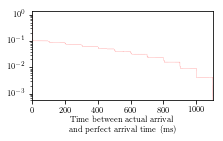

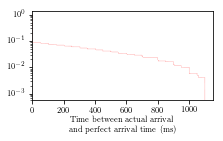

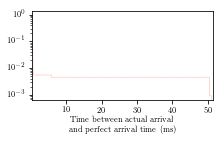

In [32]:
#CCDFs
# time between actual msgs arrival and perfect arrical time
for f in glob.iglob('./*20191128*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                                    ['seconds_offset', 'streamid', 'length', 'msg_number'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number'])

    title=f
    del dfapp['length']
    print(f)
    
    #compute the time between actual arrival time and perfect arrival time
    dfapp.sort_values(by='msg_number')
    print((dfapp.seconds_offset[0]-0.1).round(3))
    dfapp['ms_offset'] = dfapp.seconds_offset.apply(lambda x: (x-(dfapp.seconds_offset[0]-0.1).round(3)) * 1000) # from s to ms
    dfapp['perfectTimeDeviation'] = dfapp.ms_offset - dfapp.msg_number * 100
    #print(dfapp)

    sortedTimeDeviation = dfapp['perfectTimeDeviation'].sort_values()
    print(sortedTimeDeviation)
    print(dfapp)
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedTimeDeviation))
    cdf = pd.Series(cum_dist, index=sortedTimeDeviation)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between actual arrival \n and perfect arrival time (ms)')
    plt.tight_layout()
    
    #plt.savefig(f+"ccdf_perfectTimeDeviation.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"ccdf_perfectTimeDeviation_ylog.pdf")